In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
from scipy.fftpack import fft
from scipy.signal import firwin, remez, kaiser_atten, kaiser_beta
from scipy.signal import butter, filtfilt, buttord
from scipy.signal import butter, lfilter
from scipy.signal import welch
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [2]:
signals_beth = pd.read_csv('data/datafinal/bethoven.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])

#print('Estructura de la informacion:')
#print(signals_beth.head())

data_beth = signals_beth.values
eeg_beth = data_beth[:,2]

#print(len(eeg_beth))

signals_death = pd.read_csv('data/datafinal/deathmetal.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])

#print('Estructura de la informacion:')
#print(signals_death.head())

data_death = signals_death.values
eeg_death = data_death[:,2]

#print(eeg_death)

signals_baseline = pd.read_csv('data/datafinal/baseline.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])

#print('Estructura de la informacion:')
#print(signals_baseline.head())

data_baseline = signals_baseline.values
eeg_baseline = data_baseline[:,2]

#print(eeg_baseline)

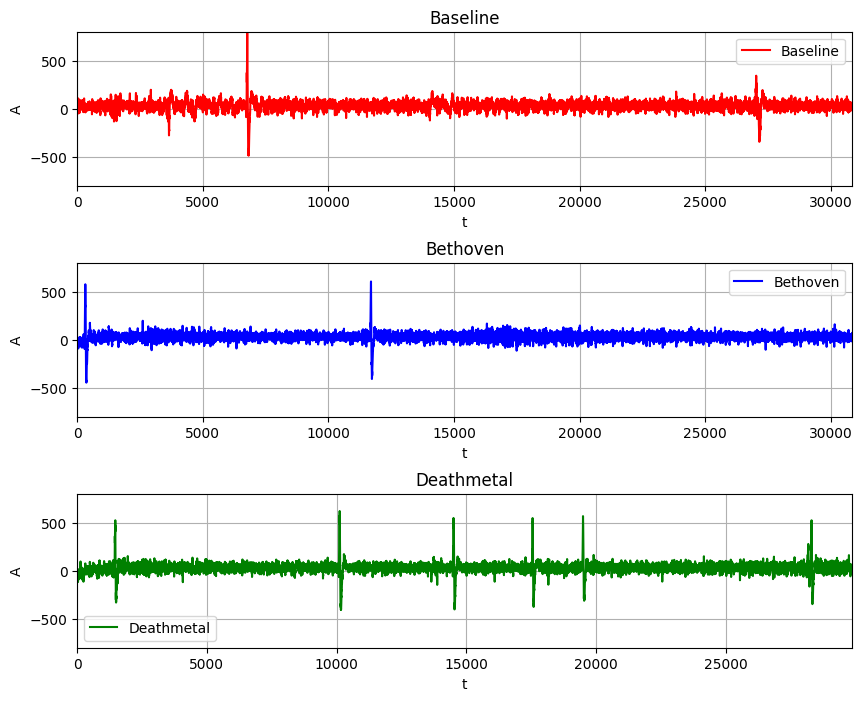

In [3]:
# Create the grid of figures (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 8))  # Set desired figure size

# Function to format and plot each subplot
def format_and_plot(data,color, label, ax, limits,xlabel):
    ax.plot(data,color, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('A')
    ax.set_title(f'{label}')  # Include subplot number in title
    ax.set_ylim([-limits, limits])
    ax.set_xlim([0, len(data)])
    ax.grid()
    ax.legend()

# Plot each subplot using the function
format_and_plot(eeg_baseline,'r', 'Baseline', axes[0],800,'t')
format_and_plot(eeg_beth,'b', 'Bethoven', axes[1],800,'t')
format_and_plot(eeg_death,'g', 'Deathmetal', axes[2],800,'t')

# Adjust layout to prevent overlapping titles
plt.subplots_adjust(hspace=0.5)
plt.show()

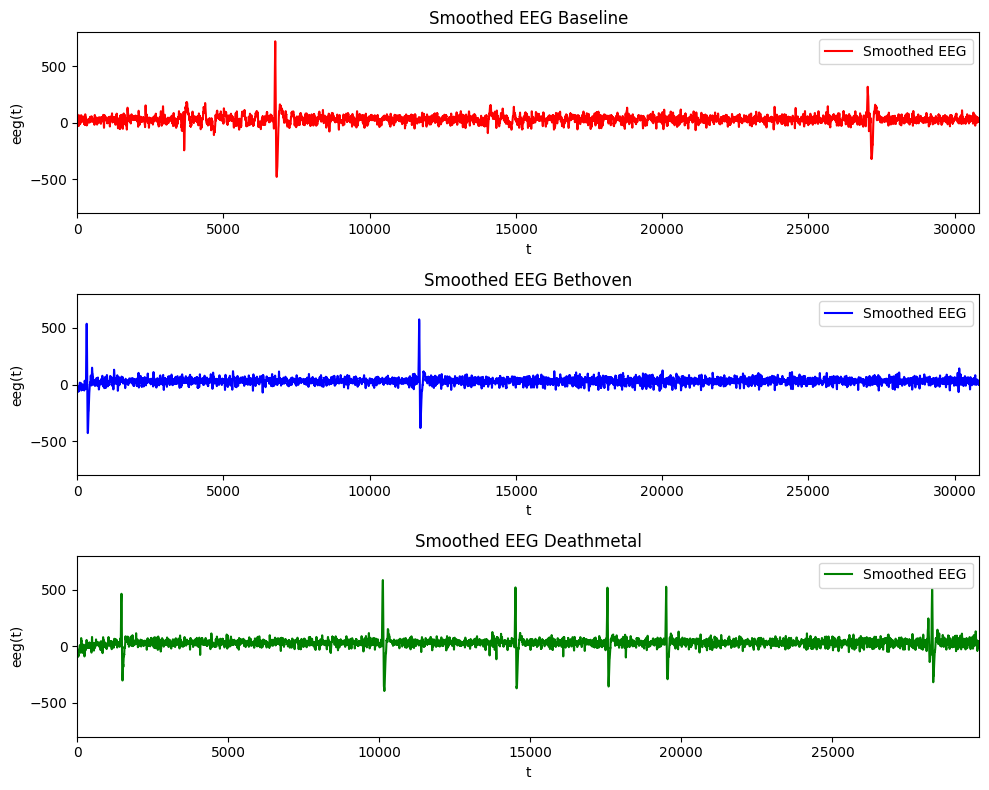

In [4]:
# La operación de convolución permite implementar el suavizado del Moving Average
windowlength = 10
avgeeg_beth = np.convolve(eeg_beth, np.ones((windowlength,))/windowlength, mode='same')
avgeeg_death = np.convolve(eeg_death, np.ones((windowlength,))/windowlength, mode='same')
avgeeg_baseline = np.convolve(eeg_baseline, np.ones((windowlength,))/windowlength, mode='same')

# Crear la grilla de gráficos (3 filas, 1 columna)
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Primer gráfico: Señal EEG original
axes[0].plot(avgeeg_baseline, 'r', label='Smoothed EEG')
axes[0].set_xlabel('t')
axes[0].set_ylabel('eeg(t)')
axes[0].set_title(r'Smoothed EEG Baseline')
axes[0].set_ylim([-800, 800])
axes[0].set_xlim([0, len(avgeeg_baseline)])
axes[0].legend()

# Segundo gráfico: Señal suavizada bethoven
axes[1].plot(avgeeg_beth, 'b', label='Smoothed EEG')
axes[1].set_xlabel('t')
axes[1].set_ylabel('eeg(t)')
axes[1].set_title(r'Smoothed EEG Bethoven')
axes[1].set_ylim([-800, 800])
axes[1].set_xlim([0, len(avgeeg_beth)])
axes[1].legend()

# Tercer gráfico: Señal suavizada deathmetal
axes[2].plot(avgeeg_death, 'g', label='Smoothed EEG')
axes[2].set_xlabel('t')
axes[2].set_ylabel('eeg(t)')
axes[2].set_title(r'Smoothed EEG Deathmetal')
axes[2].set_ylim([-800, 800])
axes[2].set_xlim([0, len(avgeeg_death)])
axes[2].legend()

# Ajustar los espacios entre gráficos
plt.tight_layout()
plt.show()

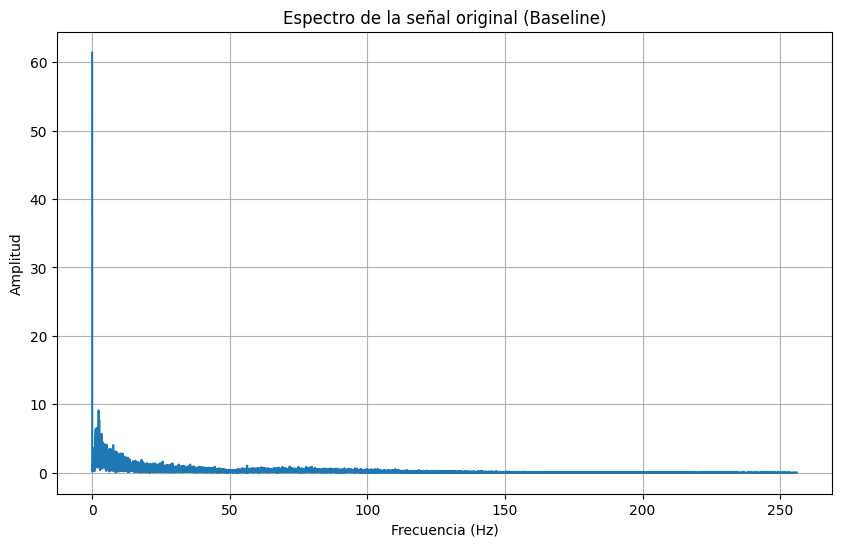

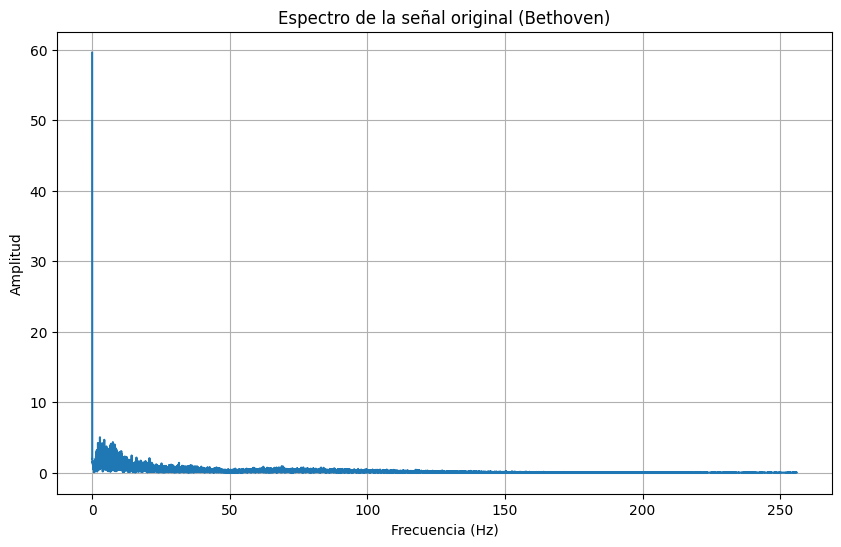

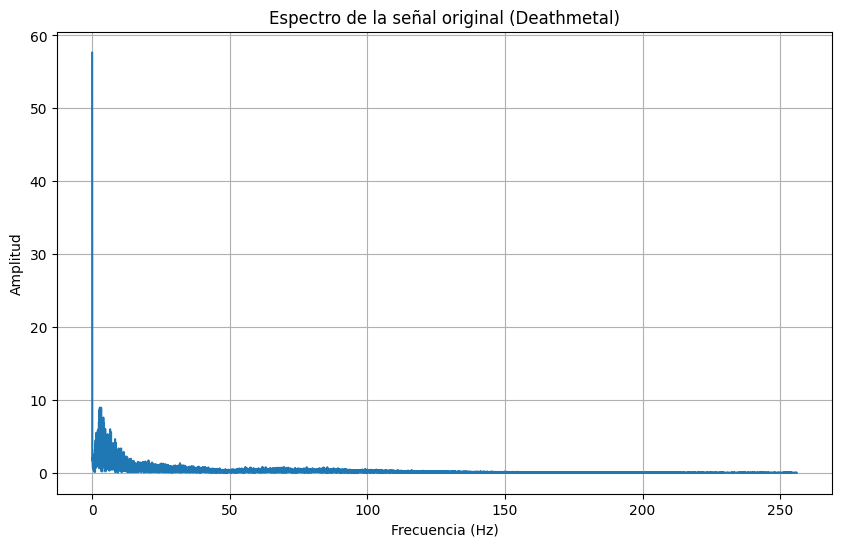

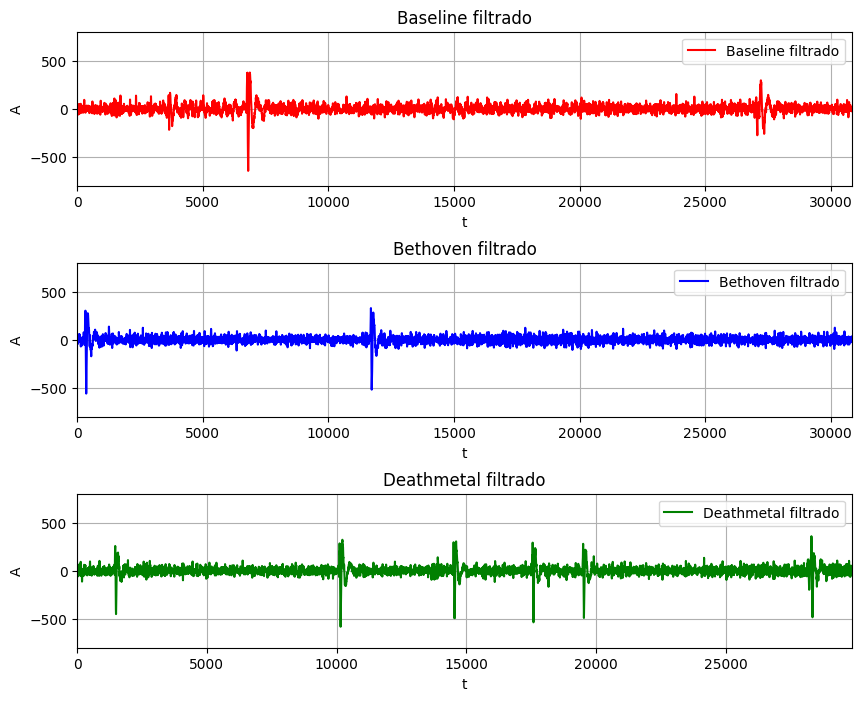

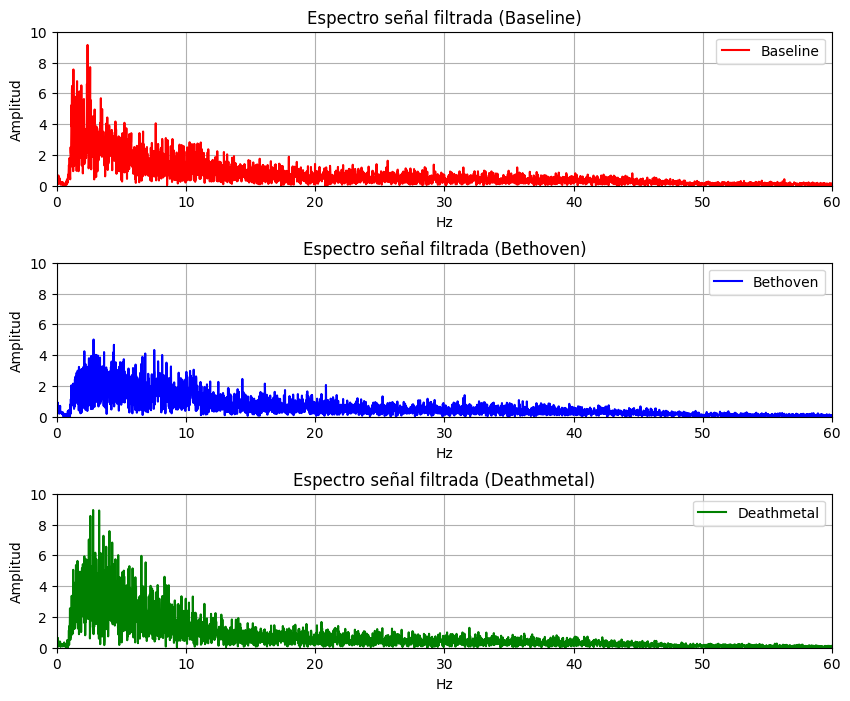

In [5]:
#-----FILTRO ESPECTRAL-----

# Filtro pasa-banda
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

Fs = 512  # Frecuencia de muestreo
N = len(eeg_baseline)  # Número de muestras en la señal
T = 1.0 / Fs  # Intervalo de tiempo entre muestras

#Baseline

# FFT de la señal original
yf = fft(eeg_baseline)
xf = np.linspace(0.0, Fs / 2, N // 2)  # Frecuencias positivas

plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0 / N * np.abs(yf[:N // 2]))
plt.title("Espectro de la señal original (Baseline)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Aplicar filtro a la señal
lowcut = 1.0  # Frecuencia de corte baja (Hz)
highcut = 50.0  # Frecuencia de corte alta (Hz)

filtered_signal = butter_bandpass_filter(eeg_baseline, lowcut, highcut, Fs, order=6)

# FFT de la señal filtrada
yf_filtered = fft(filtered_signal)

#Bethoven

# FFT de la señal original
yf1 = fft(eeg_beth)
xf = np.linspace(0.0, Fs / 2, N // 2)  # Frecuencias positivas

plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0 / N * np.abs(yf1[:N // 2]))
plt.title("Espectro de la señal original (Bethoven)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Aplicar filtro a la señal
lowcut = 1.0  # Frecuencia de corte baja (Hz)
highcut = 50.0  # Frecuencia de corte alta (Hz)

filtered_signal1 = butter_bandpass_filter(eeg_beth, lowcut, highcut, Fs, order=6)

# FFT de la señal filtrada
yf_filtered1 = fft(filtered_signal1)

#Deathmetal

# FFT de la señal original
yf2 = fft(eeg_death)
xf = np.linspace(0.0, Fs / 2, N // 2)  # Frecuencias positivas

plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0 / N * np.abs(yf2[:N // 2]))
plt.title("Espectro de la señal original (Deathmetal)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


# Aplicar filtro a la señal
lowcut = 1.0  # Frecuencia de corte baja (Hz)
highcut = 50.0  # Frecuencia de corte alta (Hz)

filtered_signal2 = butter_bandpass_filter(eeg_death, lowcut, highcut, Fs, order=6)

# FFT de la señal filtrada
yf_filtered2 = fft(filtered_signal2)

# Crear la grilla de gráficos (3 filas, 1 columna)
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Plot each subplot using the function
format_and_plot(filtered_signal,'r', 'Baseline filtrado', axes[0],800,'t')
format_and_plot(filtered_signal1,'b', 'Bethoven filtrado', axes[1],800,'t')
format_and_plot(filtered_signal2,'g', 'Deathmetal filtrado', axes[2],800,'t')

# Adjust layout to prevent overlapping titles
plt.subplots_adjust(hspace=0.5)
plt.show()


# Crear la grilla de gráficos (3 filas, 1 columna)
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Primer gráfico: Espectro de la señal filtrada (Baseline)
axes[0].plot(xf, 2.0 / N * np.abs(yf_filtered[:N // 2]), 'r', label='Baseline')
axes[0].set_xlabel('Hz')
axes[0].set_ylabel('Amplitud')
axes[0].set_ylim([0, 10])
axes[0].set_xlim([0, 60])
axes[0].set_title('Espectro señal filtrada (Baseline)')
axes[0].grid()
axes[0].legend()

# Segundo gráfico: Espectro de la señal filtrada (Bethoven)
axes[1].plot(xf, 2.0 / N * np.abs(yf_filtered1[:N // 2]), 'b', label='Bethoven')
axes[1].set_xlabel('Hz')
axes[1].set_ylabel('Amplitud')
axes[1].set_ylim([0, 10])
axes[1].set_xlim([0, 60])
axes[1].set_title('Espectro señal filtrada (Bethoven)')
axes[1].grid()
axes[1].legend()

# Tercer gráfico: Espectro de la señal filtrada (Deathmetal)
axes[2].plot(xf, 2.0 / N * np.abs(yf_filtered2[:N // 2]), 'g', label='Deathmetal')
axes[2].set_xlabel('Hz')
axes[2].set_ylabel('Amplitud')
axes[2].set_ylim([0, 10])
axes[2].set_xlim([0, 60])
axes[2].set_title('Espectro señal filtrada (Deathmetal)')
axes[2].grid()
axes[2].legend()

# Ajustar el espacio entre gráficos
plt.subplots_adjust(hspace=0.5)
plt.show()

In [6]:
def hjorth(a):

    first_deriv = np.diff(a)
    second_deriv = np.diff(a,2)

    var_zero = np.mean(a ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    morbidity = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / morbidity

    return activity, morbidity, complexity

In [7]:
activiti_baseline, morbidity_baseline, cmplexity_baseline = hjorth(eeg_baseline)
activiti_beth, morbidity_beth, cmplexity_beth = hjorth(eeg_beth)
activiti_death, morbidity_death, cmplexity_death = hjorth(eeg_death)

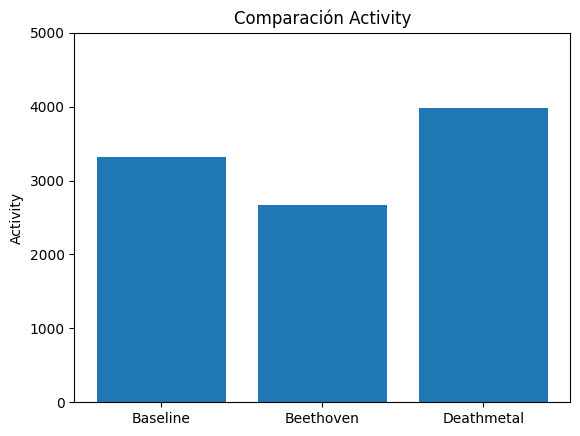

In [8]:
fig, ax = plt.subplots()

# Crear las barras
ax.bar(['Baseline', 'Beethoven', 'Deathmetal'], [activiti_baseline, activiti_beth, activiti_death])

# Personalizar el gráfico
ax.set_ylabel('Activity')
ax.set_ylim(0, 5000)
plt.title('Comparación Activity')

plt.show()

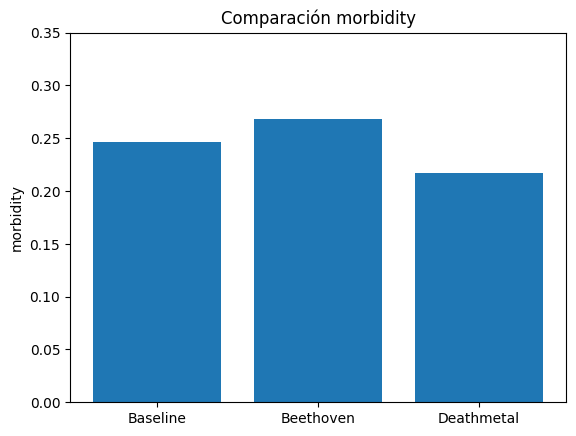

In [9]:
fig, ax = plt.subplots()

# Crear las barras
ax.bar(['Baseline', 'Beethoven', 'Deathmetal'], [morbidity_baseline, morbidity_beth, morbidity_death])

# Personalizar el gráfico
ax.set_ylabel('morbidity')
ax.set_ylim(0, 0.35)
plt.title('Comparación morbidity')

plt.show()

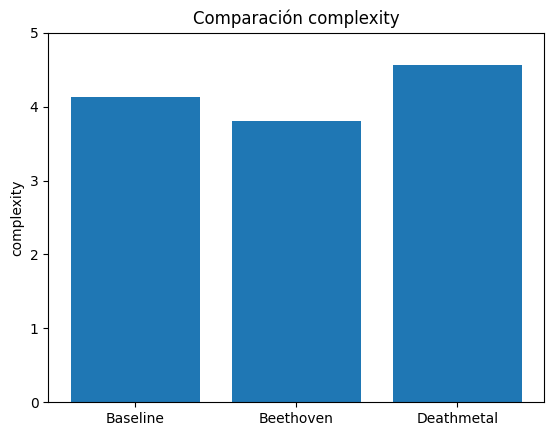

In [10]:
fig, ax = plt.subplots()

# Crear las barras
ax.bar(['Baseline', 'Beethoven', 'Deathmetal'], [cmplexity_baseline, cmplexity_beth, cmplexity_death])

# Personalizar el gráfico
ax.set_ylabel('complexity')
ax.set_ylim(0, 5)
plt.title('Comparación complexity')

plt.show()

In [11]:
def rolling_statistics(data, window_size, label, sampling_rate=128):
    data_series = pd.Series(data)
    rolling_stats = data_series.rolling(window=window_size)

    # Helper functions
    def shannon_entropy(x):
        hist, _ = np.histogram(x, bins=10, density=True)
        return entropy(hist, base=2)

    def hjorth_parameters(x):
        """Calculate Hjorth parameters: Activity, Morbidity, Complexity."""
        activity = np.var(x)
        diff = np.diff(x)
        morbidity = np.sqrt(np.var(diff) / activity)
        complexity = np.sqrt(np.var(np.diff(diff)) / np.var(diff))
        return activity, morbidity, complexity

    def power_in_band(freqs, psd, f_low, f_high):
        mask = (freqs >= f_low) & (freqs <= f_high)
        return np.sum(psd[mask])

    # Calculate rolling statistics and features
    stats = pd.DataFrame({
        "media": rolling_stats.mean(),
        "desviacion_estandar": rolling_stats.std(),
        "maximo": rolling_stats.max(),
        "minimo": rolling_stats.min(),
        "RMS": rolling_stats.apply(lambda x: np.sqrt(np.mean(x**2)), raw=False),
        "entropia": rolling_stats.apply(lambda x: shannon_entropy(x) if len(x) > 0 else np.nan, raw=False),
        "señal": label
    })

    # Hjorth parameters and band powers
    activity = []
    morbidity = []
    complexity = []
    delta_power = []
    theta_power = []
    alpha_power = []
    beta_power = []
    gamma_power = []

    for x in rolling_stats:
        if len(x) == window_size:  # Ensure the window is complete
            act, morb, comp = hjorth_parameters(x)
            activity.append(act)
            morbidity.append(morb)
            complexity.append(comp)

            # Calculate power spectral density
            freqs, psd = welch(x, fs=sampling_rate, nperseg=window_size)

            # Band power calculations (ranges are standard EEG bands)
            delta_power.append(power_in_band(freqs, psd, 0.5, 4))
            theta_power.append(power_in_band(freqs, psd, 4, 8))
            alpha_power.append(power_in_band(freqs, psd, 8, 13))
            beta_power.append(power_in_band(freqs, psd, 13, 30))
            gamma_power.append(power_in_band(freqs, psd, 30, 100))
        else:
            activity.append(np.nan)
            morbidity.append(np.nan)
            complexity.append(np.nan)
            delta_power.append(np.nan)
            theta_power.append(np.nan)
            alpha_power.append(np.nan)
            beta_power.append(np.nan)
            gamma_power.append(np.nan)

    # Add Hjorth and band power features to DataFrame
    stats["actividad"] = activity
    stats["morbidez"] = morbidity
    stats["complejidad"] = complexity
    stats["potencia_delta"] = delta_power
    stats["potencia_theta"] = theta_power
    stats["potencia_alpha"] = alpha_power
    stats["potencia_beta"] = beta_power
    stats["potencia_gamma"] = gamma_power

    return stats



In [12]:
features_bethoven = rolling_statistics(eeg_beth,15000,0)
features_bethoven.dropna(inplace=True)

features_deathmetal = rolling_statistics(eeg_death,15000,1)
features_deathmetal.dropna(inplace=True)

dataset = pd.concat([features_bethoven,features_deathmetal],axis=0)
dataset.head(2)

,media,desviacion_estandar,maximo,minimo,RMS,entropia,señal,actividad,morbidez,complejidad,potencia_delta,potencia_theta,potencia_alpha,potencia_beta,potencia_gamma
14999,28.786733,50.457222,605.0,-446.0,58.089909,0.692263,0,2545.761517,0.267270,1.012952,86695.139839,18563.226047,7654.413217,12964.454989,1059.460051
15000,28.785933,50.457932,605.0,-446.0,58.090129,0.692263,0,2545.833175,0.267263,1.012945,86728.567917,18562.910873,7653.523346,12962.440667,1059.176283


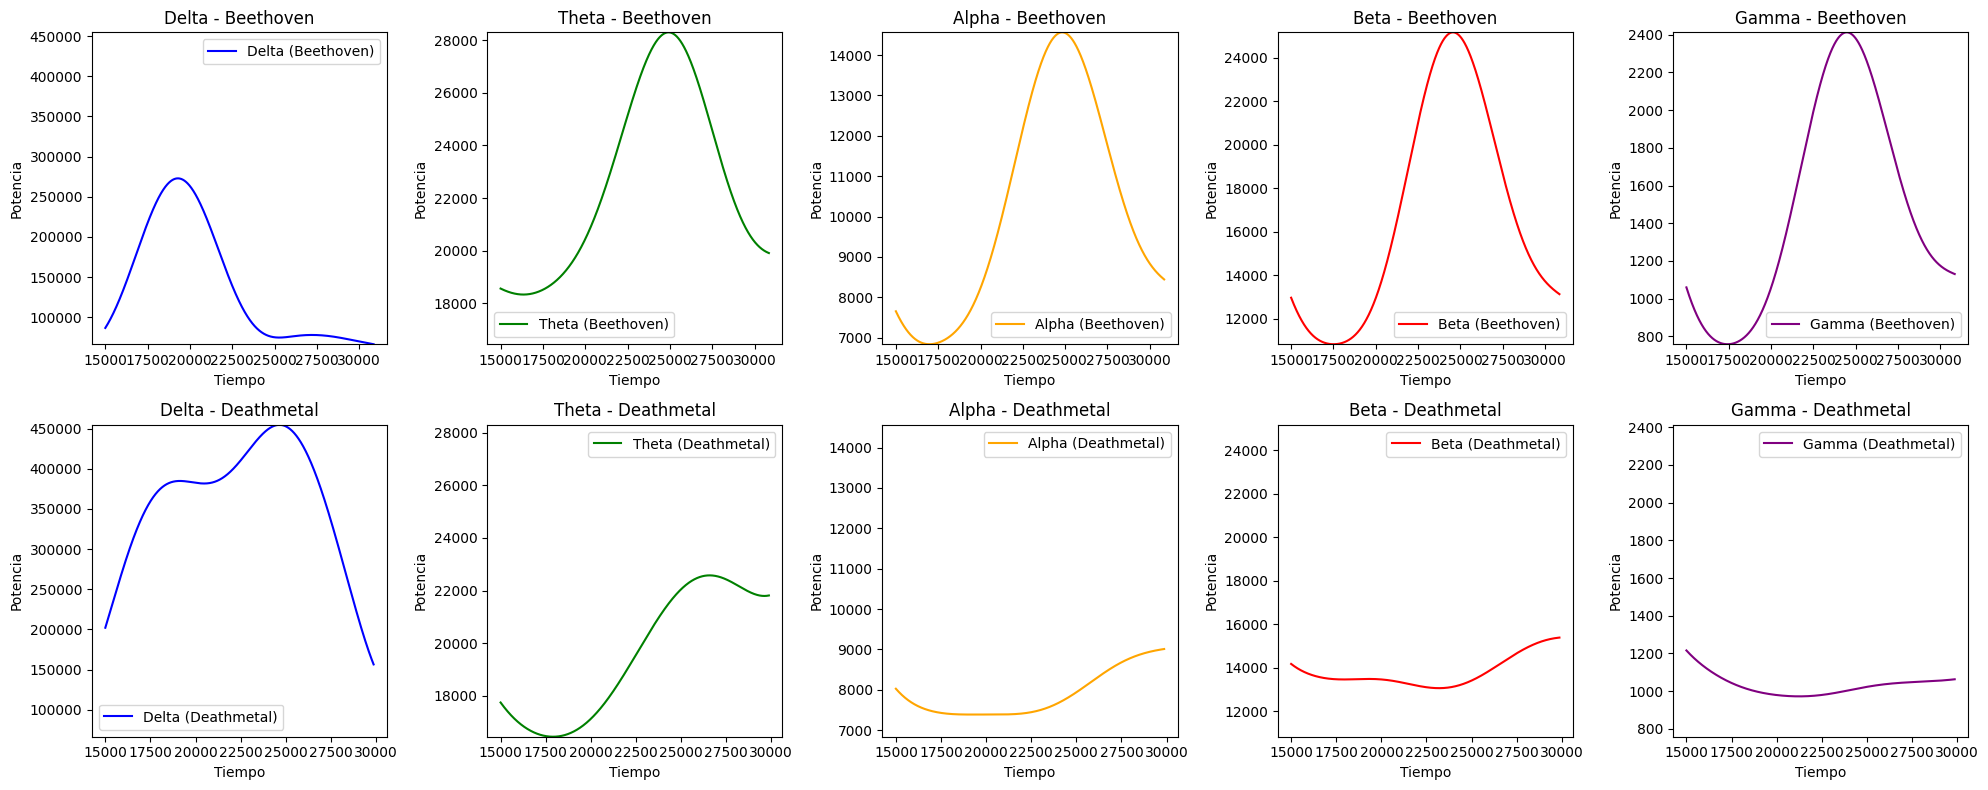

In [13]:
potencias = ['potencia_delta', 'potencia_theta', 'potencia_alpha', 'potencia_beta', 'potencia_gamma']

# Seleccionar las columnas necesarias y renombrarlas para un manejo más claro
beethoven = features_bethoven[potencias].rename(columns={
    'potencia_delta': 'Delta',
    'potencia_theta': 'Theta',
    'potencia_alpha': 'Alpha',
    'potencia_beta': 'Beta',
    'potencia_gamma': 'Gamma'
})

deathmetal = features_deathmetal[potencias].rename(columns={
    'potencia_delta': 'Delta',
    'potencia_theta': 'Theta',
    'potencia_alpha': 'Alpha',
    'potencia_beta': 'Beta',
    'potencia_gamma': 'Gamma'
})

# Crear una grilla de subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 filas (Beethoven y Deathmetal), 5 columnas (bandas)

# Definir colores y títulos
bands = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
colors = ["blue", "green", "orange", "red", "purple"]

# Calcular límites compartidos para Beethoven y Deathmetal en cada banda
y_lims = {band: (min(beethoven[band].min(), deathmetal[band].min()), 
                 max(beethoven[band].max(), deathmetal[band].max())) for band in bands}

# Plot para Beethoven (fila 0)
for i, band in enumerate(bands):
    ax = axes[0, i]
    ax.plot(beethoven.index, beethoven[band], color=colors[i], label=f"{band} (Beethoven)")
    ax.set_title(f"{band} - Beethoven")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Potencia")
    ax.set_ylim(y_lims[band])  # Igualar la escala de potencia entre ambos DataFrames
    ax.legend()

# Plot para Deathmetal (fila 1)
for i, band in enumerate(bands):
    ax = axes[1, i]
    ax.plot(deathmetal.index, deathmetal[band], color=colors[i], label=f"{band} (Deathmetal)")
    ax.set_title(f"{band} - Deathmetal")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Potencia")
    ax.set_ylim(y_lims[band])  # Igualar la escala de potencia entre ambos DataFrames
    ax.legend()

# Ajustar diseño
plt.tight_layout()
plt.show()

In [41]:
# Armado del clasificador

# Paso 1: Preparar los datos
X = dataset.drop(columns=['señal'])  # Variables independientes (todas menos 'señal')
y = dataset['señal']  # Variable dependiente (columna 'señal')

# Paso 2: Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
# Paso 3: Entrenar el modelo SVM
model = SVC(kernel='rbf')  # Puedes probar otros kernels como 'rbf' o 'poly'
model.fit(X_train, y_train)


SVC()

In [43]:
# Paso 4: Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

In [44]:
# Paso 5: Evaluar el modelo

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[4838    0]
 [ 797 3582]]


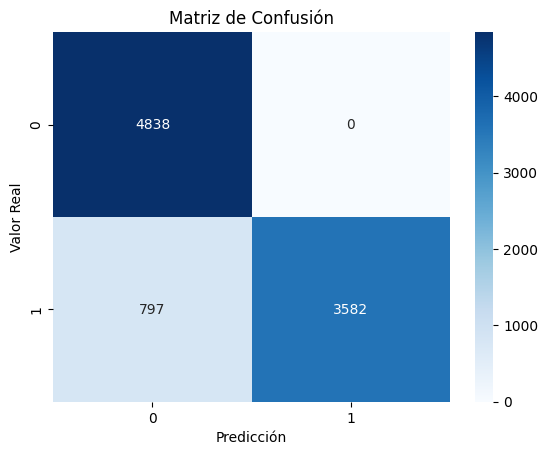

In [46]:
# Mostrar la matriz de confusión con un mapa de calor
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


In [45]:

# Calcular el accuracy (exactitud)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Reporte con la sensibilidad, especificidad, y otros parámetros
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Extra: Sensibilidad y Especificidad
# Sensibilidad (recall): tp / (tp + fn)
# Especificidad: tn / (tn + fp)
tn, fp, fn, tp = cm.ravel()
sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)

print(f"Sensibilidad: {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")

Accuracy: 0.9135
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      4838
           1       1.00      0.82      0.90      4379

    accuracy                           0.91      9217
   macro avg       0.93      0.91      0.91      9217
weighted avg       0.93      0.91      0.91      9217

Sensibilidad: 0.8180
Especificidad: 1.0000


In [19]:
cols_death = {'media':'media1',
              'desviacion_estandar':'desviacion_estandar1',
              'maximo':'maximo1',
              'minimo':'minimo1',
              'RMS':'RMS1',
              'entropia':'entropia1',
              'actividad':'actividad1',
              'morbidez':'morbidez1',
              'complejidad':'complejidad1',
              'potencia_delta':'potencia_delta1',
              'potencia_theta':'potencia_theta1',
              'potencia_alpha':'potencia_alpha1',
              'potencia_beta':'potencia_beta1',
              'potencia_gamma':'potencia_gamma1'}

test_death = features_deathmetal.rename(columns=cols_death)

In [20]:
test_death

,media1,desviacion_estandar1,maximo1,minimo1,RMS1,entropia1,señal,actividad1,morbidez1,complejidad1,potencia_delta1,potencia_theta1,potencia_alpha1,potencia_beta1,potencia_gamma1
255,-23.800781,42.808046,96.0,-118.0,48.906520,2.942687,1,1825.370468,0.260201,0.917359,3171.299244,973.017973,232.469777,154.004684,9.997648
256,-23.683594,42.807337,96.0,-118.0,48.848978,2.943275,1,1825.310043,0.261645,0.917875,3165.808050,978.466793,235.264725,153.888962,10.086056
257,-23.550781,42.821716,96.0,-118.0,48.797293,2.943668,1,1826.536484,0.261711,0.919548,3158.782139,983.634064,237.989708,153.774331,10.177014
258,-23.414062,42.828070,96.0,-118.0,48.737018,2.943864,1,1827.078552,0.261481,0.919150,3150.848673,988.518526,240.641263,153.660917,10.270451
259,-23.257812,42.818311,96.0,-118.0,48.653591,2.943864,1,1826.246033,0.261463,0.917690,3141.177035,993.119619,243.215715,153.548761,10.366134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29864,30.250000,39.928269,162.0,-58.0,50.031006,2.849516,1,1588.039062,0.327138,0.999448,3061.078410,603.592207,264.077521,303.777224,19.926376
29865,30.347656,39.894373,162.0,-58.0,50.063202,2.847846,1,1585.343979,0.328015,0.997795,3072.458920,607.235320,263.702406,304.226722,19.866861
29866,30.484375,39.874014,162.0,-58.0,50.130065,2.845856,1,1583.726318,0.328752,0.994898,3082.787862,610.677515,263.205136,304.611432,19.810558
29867,30.640625,39.875735,162.0,-58.0,50.226596,2.845574,1,1583.863037,0.328890,0.994615,3092.547313,613.912196,262.585380,304.931142,19.757615


In [21]:
test_beeth = features_bethoven.transpose()
test_death = test_death.transpose()

In [25]:
test_beeth.shape

(15, 30595)

In [26]:
test_death.shape

(15, 29614)

In [28]:
borrar = test_death.shape[1] - test_beeth.shape[1]

In [30]:
cols_borrar = test_beeth.columns[borrar:]

In [31]:
test_beeth.drop(cols_borrar, axis=1, inplace=True)

In [33]:
test_beeth.shape

(15, 29614)

In [38]:
partir = int(test_beeth.shape[1]/2)
partir

14807

In [43]:
cols_partirb = test_beeth.columns[partir:]
cols_partirb

Index([15062, 15063, 15064, 15065, 15066, 15067, 15068, 15069, 15070, 15071,
       ...
       29859, 29860, 29861, 29862, 29863, 29864, 29865, 29866, 29867, 29868],
      dtype='int64', length=14807)

In [46]:
cols_partird = list(test_death.columns[partir:])
cols_partird

[15062,
 15063,
 15064,
 15065,
 15066,
 15067,
 15068,
 15069,
 15070,
 15071,
 15072,
 15073,
 15074,
 15075,
 15076,
 15077,
 15078,
 15079,
 15080,
 15081,
 15082,
 15083,
 15084,
 15085,
 15086,
 15087,
 15088,
 15089,
 15090,
 15091,
 15092,
 15093,
 15094,
 15095,
 15096,
 15097,
 15098,
 15099,
 15100,
 15101,
 15102,
 15103,
 15104,
 15105,
 15106,
 15107,
 15108,
 15109,
 15110,
 15111,
 15112,
 15113,
 15114,
 15115,
 15116,
 15117,
 15118,
 15119,
 15120,
 15121,
 15122,
 15123,
 15124,
 15125,
 15126,
 15127,
 15128,
 15129,
 15130,
 15131,
 15132,
 15133,
 15134,
 15135,
 15136,
 15137,
 15138,
 15139,
 15140,
 15141,
 15142,
 15143,
 15144,
 15145,
 15146,
 15147,
 15148,
 15149,
 15150,
 15151,
 15152,
 15153,
 15154,
 15155,
 15156,
 15157,
 15158,
 15159,
 15160,
 15161,
 15162,
 15163,
 15164,
 15165,
 15166,
 15167,
 15168,
 15169,
 15170,
 15171,
 15172,
 15173,
 15174,
 15175,
 15176,
 15177,
 15178,
 15179,
 15180,
 15181,
 15182,
 15183,
 15184,
 15185,
 15186,


In [49]:
beeth_train = test_beeth.drop(cols_partirb,axis=1)
beeth_test = test_beeth[cols_partirb]

In [50]:
death_train = test_death.drop(cols_partirb,axis=1)
death_test = test_death[cols_partirb]

In [58]:
print(f'Beeth train: {beeth_train.columns}, \ntest: {beeth_test.columns}.  \n Death train: {death_train.columns}, \ntest: {death_test.columns}')

Beeth train: Index([  255,   256,   257,   258,   259,   260,   261,   262,   263,   264,
       ...
       15052, 15053, 15054, 15055, 15056, 15057, 15058, 15059, 15060, 15061],
      dtype='int64', length=14807), 
test: Index([15062, 15063, 15064, 15065, 15066, 15067, 15068, 15069, 15070, 15071,
       ...
       29859, 29860, 29861, 29862, 29863, 29864, 29865, 29866, 29867, 29868],
      dtype='int64', length=14807).  
 Death train: Index([  255,   256,   257,   258,   259,   260,   261,   262,   263,   264,
       ...
       15052, 15053, 15054, 15055, 15056, 15057, 15058, 15059, 15060, 15061],
      dtype='int64', length=14807), 
test: Index([15062, 15063, 15064, 15065, 15066, 15067, 15068, 15069, 15070, 15071,
       ...
       29859, 29860, 29861, 29862, 29863, 29864, 29865, 29866, 29867, 29868],
      dtype='int64', length=14807)


In [71]:
death_train['señal'] = 1
death_test['señal'] = 1
beeth_test['señal'] = 0
beeth_train['señal'] = 0

C:\Users\amado\AppData\Local\Temp\ipykernel_29212\103584126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  death_test['señal'] = 1
C:\Users\amado\AppData\Local\Temp\ipykernel_29212\103584126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beeth_test['señal'] = 0


In [72]:
df_train = pd.concat([beeth_train,death_train], axis=0)
df_train

,255,256,257,258,259,260,261,262,263,264,...,15053,15054,15055,15056,15057,15058,15059,15060,15061,señal
media,-25.812500,-25.550781,-25.347656,-25.183594,-25.042969,-24.929688,-24.859375,-24.785156,-24.679688,-24.503906,...,32.445312,32.464844,32.539062,32.636719,32.757812,32.933594,33.109375,33.234375,33.281250,0
desviacion_estandar,26.727308,27.206497,27.574644,27.825956,27.983365,28.090801,28.163315,28.248698,28.339381,28.451817,...,28.755305,28.757382,28.783275,28.827221,28.855895,28.823185,28.727997,28.674778,28.675996,0
maximo,55.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,0
minimo,-91.000000,-91.000000,-91.000000,-91.000000,-91.000000,-91.000000,-91.000000,-91.000000,-91.000000,-91.000000,...,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,0
RMS,37.119318,37.284642,37.415164,37.489634,37.512133,37.516663,37.524159,37.538990,37.537585,37.507135,...,43.316694,43.332697,43.405429,43.507677,43.617478,43.728164,43.798455,43.858348,43.894672,0
entropia,2.858258,2.860843,2.874978,2.891490,2.896875,2.901822,2.906344,2.908396,2.912236,2.916448,...,2.867248,2.867248,2.865859,2.868697,2.871208,2.868946,2.866451,2.865635,2.863721,0
actividad,711.558594,737.302109,757.390854,771.259262,780.009872,786.010681,790.073975,794.871811,799.983337,806.343735,...,823.637634,823.756577,825.240662,827.762558,829.410095,827.530746,822.073975,819.031006,819.100586,0
morbidez,0.359685,0.352920,0.348559,0.346011,0.345519,0.344224,0.343344,0.341361,0.338737,0.336552,...,0.409413,0.410523,0.411280,0.410375,0.407902,0.407918,0.409311,0.407049,0.406092,0
complejidad,0.885440,0.887583,0.887776,0.885647,0.880038,0.880269,0.875442,0.878806,0.883974,0.886514,...,1.032126,1.030629,1.026677,1.026871,1.032102,1.027731,1.025575,1.032516,1.025100,0
potencia_delta,541.526136,525.196042,510.484404,496.899474,484.078377,472.062915,461.098892,450.297275,439.208149,427.261693,...,1161.715919,1163.400058,1164.887761,1166.416229,1168.021544,1169.599697,1171.464714,1173.807426,1176.653119,0


In [73]:
df_test = pd.concat([beeth_test,death_test], axis=0)
df_test

,15062,15063,15064,15065,15066,15067,15068,15069,15070,15071,...,29860,29861,29862,29863,29864,29865,29866,29867,29868,señal
media,33.296875,33.355469,33.468750,33.601562,33.710938,33.738281,33.714844,33.652344,33.531250,33.343750,...,30.792969,30.781250,30.718750,30.671875,30.667969,30.683594,30.679688,30.710938,30.789062,0
desviacion_estandar,28.681308,28.683715,28.636447,28.573357,28.536225,28.525425,28.535921,28.555008,28.542624,28.472880,...,35.148203,35.139261,35.094145,35.056170,35.053840,35.055327,35.056466,35.041522,35.015213,0
maximo,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,0
minimo,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,...,-74.000000,-74.000000,-74.000000,-74.000000,-74.000000,-74.000000,-74.000000,-74.000000,-74.000000,0
RMS,43.909975,43.955988,44.011362,44.071675,44.131196,44.145135,44.133985,44.098567,43.998224,43.810316,...,46.677375,46.662937,46.587871,46.528469,46.524145,46.535563,46.533842,46.543243,46.575124,0
entropia,2.863721,2.861589,2.860752,2.859635,2.858393,2.856872,2.858393,2.859635,2.862604,2.860909,...,2.870275,2.869030,2.867556,2.865853,2.865853,2.865853,2.867682,2.867682,2.865853,0
actividad,819.404053,819.541611,816.842773,813.247498,811.135193,810.521347,811.117905,812.203354,811.499023,807.538086,...,1230.570419,1229.944336,1226.788086,1224.134521,1223.971786,1224.075668,1224.155212,1223.111755,1221.275818,0
morbidez,0.405000,0.402629,0.403415,0.404028,0.404084,0.404957,0.404701,0.402253,0.400960,0.399794,...,0.290738,0.291464,0.292179,0.291712,0.289541,0.290106,0.290844,0.290985,0.291203,0
complejidad,1.027198,1.030440,1.028507,1.029868,1.030837,1.031180,1.030229,1.036411,1.022634,1.028264,...,0.930156,0.930659,0.925940,0.930819,0.937250,0.938834,0.934394,0.935401,0.938517,0
potencia_delta,1179.784376,1182.986755,1186.294586,1189.844663,1193.712911,1197.895727,1202.287005,1206.832774,1211.483492,1216.183210,...,2109.426270,2099.458226,2089.794890,2079.726346,2068.936649,2057.724457,2046.616624,2034.954029,2022.604184,0


In [74]:
X_train = df_train.drop('señal', axis=1)
y_train = df_train['señal']
X_test = df_test.drop('señal', axis=1)
y_test = df_test['señal']

In [76]:
# Paso 3: Entrenar el modelo SVM
model = SVC(kernel='rbf')  # Puedes probar otros kernels como 'rbf' o 'poly'
model.fit(X_train, y_train)

SVC()

In [77]:
# Paso 4: Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

In [78]:
# Paso 5: Evaluar el modelo

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[14  0]
 [13  1]]


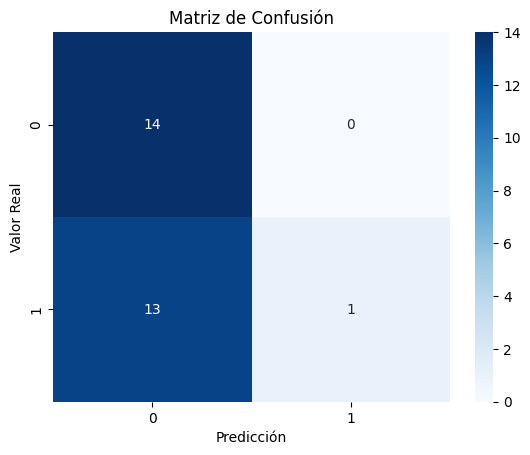

In [79]:
# Mostrar la matriz de confusión con un mapa de calor
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


In [80]:

# Calcular el accuracy (exactitud)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Reporte con la sensibilidad, especificidad, y otros parámetros
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Extra: Sensibilidad y Especificidad
# Sensibilidad (recall): tp / (tp + fn)
# Especificidad: tn / (tn + fp)
tn, fp, fn, tp = cm.ravel()
sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)

print(f"Sensibilidad: {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")

Accuracy: 0.5357
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        14
           1       1.00      0.07      0.13        14

    accuracy                           0.54        28
   macro avg       0.76      0.54      0.41        28
weighted avg       0.76      0.54      0.41        28

Sensibilidad: 0.0714
Especificidad: 1.0000


In [81]:
from sklearn.ensemble import RandomForestClassifier


In [82]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [83]:
y_pred = model.predict(X_test)

In [84]:
# Calcular el accuracy (exactitud)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Reporte con la sensibilidad, especificidad, y otros parámetros
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Extra: Sensibilidad y Especificidad
# Sensibilidad (recall): tp / (tp + fn)
# Especificidad: tn / (tn + fp)
tn, fp, fn, tp = cm.ravel()
sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)

print(f"Sensibilidad: {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")

Accuracy: 0.4643
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.46      0.43      0.44        14
           1       0.47      0.50      0.48        14

    accuracy                           0.46        28
   macro avg       0.46      0.46      0.46        28
weighted avg       0.46      0.46      0.46        28

Sensibilidad: 0.0714
Especificidad: 1.0000


In [85]:
# Paso 5: Evaluar el modelo

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[6 8]
 [7 7]]


In [86]:
from sklearn.tree import DecisionTreeClassifier

In [87]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [88]:
y_pred = model.predict(X_test)

In [89]:
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[7 7]
 [6 8]]


In [90]:
# Calcular el accuracy (exactitud)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Reporte con la sensibilidad, especificidad, y otros parámetros
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Extra: Sensibilidad y Especificidad
# Sensibilidad (recall): tp / (tp + fn)
# Especificidad: tn / (tn + fp)
tn, fp, fn, tp = cm.ravel()
sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)

print(f"Sensibilidad: {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")

Accuracy: 0.5357
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.54      0.50      0.52        14
           1       0.53      0.57      0.55        14

    accuracy                           0.54        28
   macro avg       0.54      0.54      0.54        28
weighted avg       0.54      0.54      0.54        28

Sensibilidad: 0.5714
Especificidad: 0.5000


In [92]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None,1,3, 5, 10,15,20,30],
    'min_samples_split': [2, 4,6,8 ,10]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

In [93]:
best_params

{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 6}

In [94]:
model = DecisionTreeClassifier(**best_params)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=6)

In [95]:
y_pred = model.predict(X_test)

In [96]:
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[5 9]
 [7 7]]


In [97]:
# Calcular el accuracy (exactitud)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Reporte con la sensibilidad, especificidad, y otros parámetros
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Extra: Sensibilidad y Especificidad
# Sensibilidad (recall): tp / (tp + fn)
# Especificidad: tn / (tn + fp)
tn, fp, fn, tp = cm.ravel()
sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)

print(f"Sensibilidad: {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")

Accuracy: 0.4286
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.42      0.36      0.38        14
           1       0.44      0.50      0.47        14

    accuracy                           0.43        28
   macro avg       0.43      0.43      0.43        28
weighted avg       0.43      0.43      0.43        28

Sensibilidad: 0.5000
Especificidad: 0.3571
